# Part I - The Ford GoBike sharing system
## by Timo Becker

## Introduction

Ford GoBike data set containing information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# loading data
bikes = pd.read_csv("201902-fordgobike-tripdata.csv")

In [3]:
# shape of data
bikes.shape

(183412, 16)

In [4]:
#show some data
bikes.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No


In [5]:
#check if SNA values are available
bikes.isnull().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

In [6]:
#remove nan values
bikes_cleaned = bikes.dropna(subset=['duration_sec', 'member_birth_year'])

In [7]:
#Check
nan_indices = bikes_cleaned.isna() 
nan_indices.sum()

duration_sec                 0
start_time                   0
end_time                     0
start_station_id           195
start_station_name         195
start_station_latitude       0
start_station_longitude      0
end_station_id             195
end_station_name           195
end_station_latitude         0
end_station_longitude        0
bike_id                      0
user_type                    0
member_birth_year            0
member_gender                0
bike_share_for_all_trip      0
dtype: int64

In [8]:
bikes_cleaned.shape

(175147, 16)

In [9]:
#check for duplicates
bikes_cleaned.duplicated().sum()

0

In [10]:
# same in percent
pd.DataFrame(((bikes_cleaned.count()-bikes_cleaned.isnull().sum())/bikes_cleaned.count())*100 , columns=['Coverage'])

,Coverage
duration_sec,100.000000
start_time,100.000000
end_time,100.000000
start_station_id,99.888541
start_station_name,99.888541
start_station_latitude,100.000000
start_station_longitude,100.000000
end_station_id,99.888541
end_station_name,99.888541
end_station_latitude,100.000000


We can see here, that the data are very healthy. Good for further steps

In [12]:
#show datatypes
bikes_cleaned.dtypes

duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object

### Lets convert start/endtypes to datetime

In [13]:
#convert start and endtime
bikes_cleaned['start_time'] = pd.to_datetime(bikes_cleaned['start_time'])
bikes_cleaned['end_time'] = pd.to_datetime(bikes_cleaned['end_time'])

In [14]:
# create attributes for dayof week
WeekDays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
test = bikes_cleaned.start_time.dt.dayofweek
print(test)

0         3
2         3
3         3
4         3
5         3
         ..
183407    4
183408    4
183409    4
183410    4
183411    4
Name: start_time, Length: 175147, dtype: int64


### Create Weekday start and end

In [15]:
#add days
bikes_cleaned['weekday_end'] = bikes_cleaned.end_time.dt.dayofweek.map(WeekDays)
bikes_cleaned['weekday_start'] = bikes_cleaned.start_time.dt.dayofweek.map(WeekDays)

In [16]:
bikes_cleaned.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,weekday_end,weekday_start
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No,Friday,Thursday
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No,Friday,Thursday
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No,Friday,Thursday
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes,Friday,Thursday
5,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,323.0,Broadway at Kearny,37.798014,-122.405950,5200,Subscriber,1959.0,Male,No,Friday,Thursday


### What is the structure of your dataset?

The data contains 183412 records for 16 columns before cleaning. 

### What is/are the main feature(s) of interest in your dataset?

I am interested in what are the characteristics (age, sex, and user_type) of the riders and the duration of the trips. Also if there is a correlation between age and duration of rides.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
- Duration of rides
- Gender types
- Birthyear, because with that attribute I can calculate the age of the users

# Univariate Exploration

In [17]:
# get actual year
current_year = datetime.datetime.now().year #get current year

In [18]:
#create new coloumn with actual age
age_cleaned = current_year - bikes_cleaned['member_birth_year']
age = current_year - bikes['member_birth_year']

bikes_cleaned.loc[:, 'member_age'] = age_cleaned
bikes.loc[:, 'member_age'] = age

In [19]:
#test
bikes_cleaned.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,weekday_end,weekday_start,member_age
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No,Friday,Thursday,39.0
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No,Friday,Thursday,51.0


In [20]:
bikes.describe(include = 'all')

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,member_age
count,183412.000000,183412,183412,183215.000000,183215,183412.000000,183412.000000,183215.000000,183215,183412.000000,183412.000000,183412.000000,183412,175147.000000,175147,183412,175147.000000
unique,NaN,183401,183397,NaN,329,NaN,NaN,NaN,329,NaN,NaN,NaN,2,NaN,3,2,NaN
top,NaN,2019-02-25 08:52:07.5820,2019-02-11 08:03:22.6020,NaN,Market St at 10th St,NaN,NaN,NaN,San Francisco Caltrain Station 2 (Townsend St...,NaN,NaN,NaN,Subscriber,NaN,Male,No,NaN
freq,NaN,2,2,NaN,3904,NaN,NaN,NaN,4857,NaN,NaN,NaN,163544,NaN,130651,166053,NaN
mean,726.078435,NaN,NaN,138.590427,NaN,37.771223,-122.352664,136.249123,NaN,37.771427,-122.352250,4472.906375,NaN,1984.806437,NaN,NaN,38.193563
std,1794.389780,NaN,NaN,111.778864,NaN,0.099581,0.117097,111.515131,NaN,0.099490,0.116673,1664.383394,NaN,10.116689,NaN,NaN,10.116689
min,61.000000,NaN,NaN,3.000000,NaN,37.317298,-122.453704,3.000000,NaN,37.317298,-122.453704,11.000000,NaN,1878.000000,NaN,NaN,22.000000
25%,325.000000,NaN,NaN,47.000000,NaN,37.770083,-122.412408,44.000000,NaN,37.770407,-122.411726,3777.000000,NaN,1980.000000,NaN,NaN,31.000000
50%,514.000000,NaN,NaN,104.000000,NaN,37.780760,-122.398285,100.000000,NaN,37.781010,-122.398279,4958.000000,NaN,1987.000000,NaN,NaN,36.000000
75%,796.000000,NaN,NaN,239.000000,NaN,37.797280,-122.286533,235.000000,NaN,37.797320,-122.288045,5502.000000,NaN,1992.000000,NaN,NaN,43.000000


- What we see directly is the maximum value of duration in seconds. It looks like that the maximum is 85444s which is equal to approx 24hours. Also we can see that the min durations is only 61s.

- Also we can see which start and end stations the most popular (start: Market St at 10th St with 3904; End: San Francisco Caltrain Station 2 with 4857). So this should be is one of the profitable stations for GoBike.

- The most people who are using the bike sharing service are males (130651)

- The most people who are using the bike sharing service are subscribers (163544) and no costumers

- We can see that some people have given fake birth years (1878) which leads to an age over 100 years :D

### Lets check rental duration of bikes

The duration of the trip can be an important point for the analysis. This would help us to identify the users and also to assess the time they need for the journey.

In [21]:
#Check duration coloumn
bikes_cleaned['duration_sec'].describe().to_frame()

,duration_sec
count,175147.000000
mean,704.211845
std,1641.608363
min,61.000000
25%,323.000000
50%,510.000000
75%,789.000000
max,84548.000000


As we can see with the describe method the most trip durations are below 1000s. So it makes sense to find outliers to the pertaining data.

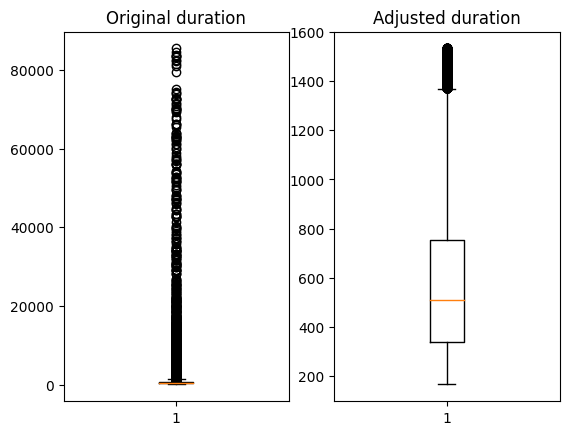

In [22]:
#check outliers with boxplot
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

bikes_series_adjusted = bikes_cleaned['duration_sec'][bikes_cleaned['duration_sec'].between(bikes_cleaned['duration_sec'].quantile(.05), bikes_cleaned['duration_sec'].quantile(.95))] 
ax1.boxplot(bikes['duration_sec'])
ax1.set_title('Original duration')

ax2.boxplot(bikes_series_adjusted)
ax2.set_title('Adjusted duration')

plt.show()

As we can see here, the most data are between 350s and 800s.

In the next step I will check the datapoints below specific thresholds:

In [23]:
# Check how many datas are below 1000s and above 1000s
print("Length of duration below 1000 : " +
      str(bikes_cleaned.query('duration_sec < 1000').shape[0]))
print("Length of duration between 1000 and 2000  : " +
      str(bikes_cleaned.query('duration_sec >= 1000 and duration_sec <= 2000').shape[0])) 
print("Length of duration above 2000  : " +
      str(bikes_cleaned.query('duration_sec > 2000').shape[0])) 
print('total sample length : ' + str(bikes_cleaned.shape[0]))

Length of duration below 1000 : 149488
Length of duration between 1000 and 2000  : 20954
Length of duration above 2000  : 4705
total sample length : 175147


We see that the majority of trips are under 2000s, no even under 1000s 

- 2,69% are above 2000s
- 97,31% are below 2001s
 
 So it make sense to plot two figures. One with the bikes_series_adjusted and one below threshold of 1000s.

[]

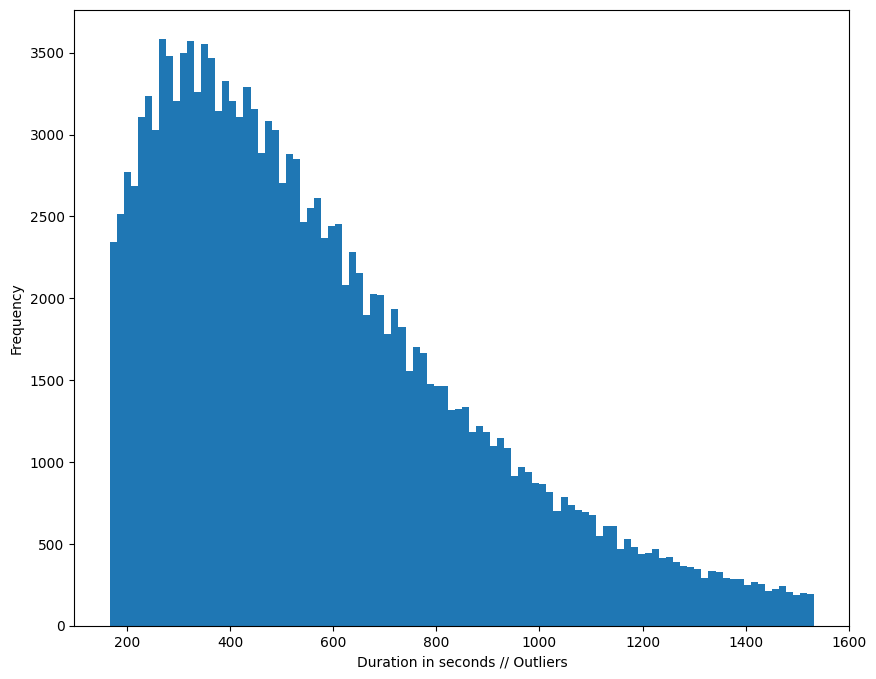

In [24]:
#Plot the duration in s from outliers boxplot
bikes_series_adjusted.plot.hist(bins = 100 ,figsize = (10 , 8)).set(xlabel = 'Duration in seconds // Outliers')
plt.plot()

In this plot we that the most rides are within an duration range of 250s to 500s. The peak of the trips goes up to 3500 trips. Lets check the same with less data points and more bins.

[]

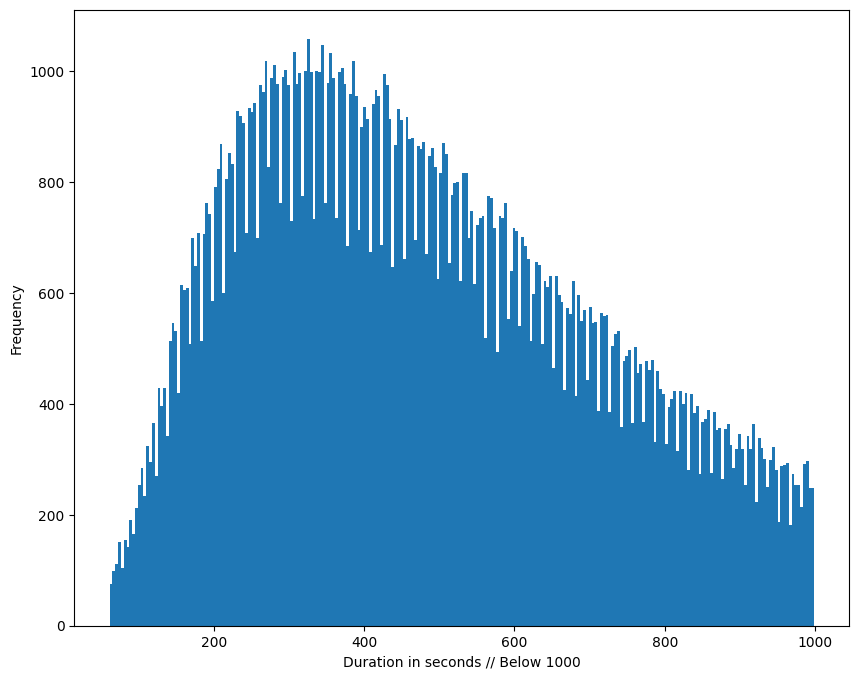

In [32]:
#Plot the duration in s below 1000s
bikes_cleaned.query('duration_sec < 1000')['duration_sec'].plot.hist(bins = 250 ,
                                                         figsize = (10 , 8)).set(xlabel = 'Duration in seconds // Below 1000')
plt.plot()

After we have filtered out the outliers and check the same with data set below 1000s ride duration, we realize that the majority of the travel durations are on average between 300-450s. The peak looks like approx. 1200s.

### Lets check: Age of users and what is their gender ? 

I am also interested in the age of users, their gender and also which type of users are using the service. 

Lets start with the age. I query all rider below 80. I did this because some fake ages are in the dataset and I think that people over 80 years doesnt rent a bike. :)

In [33]:
# remove fake ages, because people over 80 years doesnt rent a bike (my opinion :D)
bikes_cleaned = bikes_cleaned.query('member_age < 80')

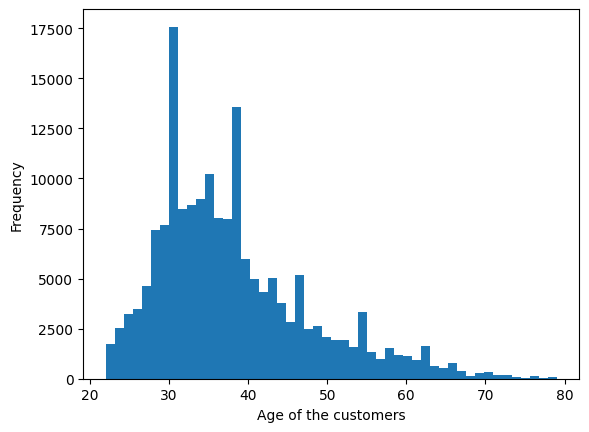

In [51]:
#create hiostogrm of member age and 
bikes_cleaned['member_age'].plot(kind = 'hist' , bins = 50).set(xlabel = 'Age of the customers')
plt.show()

Looks like a big range of riders but with an average between mid 20 and 40 years.

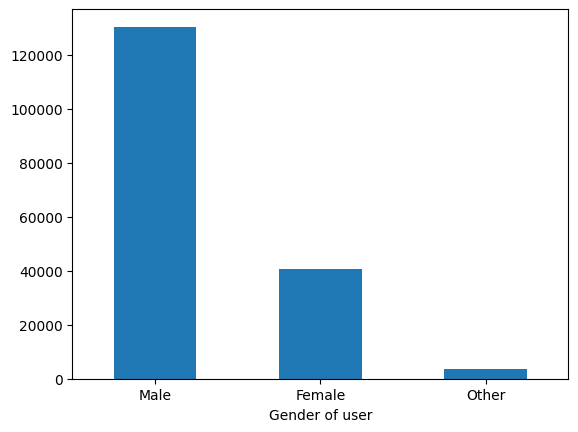

In [52]:
# create bar plot user gender
(bikes_cleaned.member_gender.value_counts().plot(kind = 'bar',rot = 0).set(xlabel = 'Gender of user'))
plt.show()

The most riders are male. Why so less female and what are the "others"?

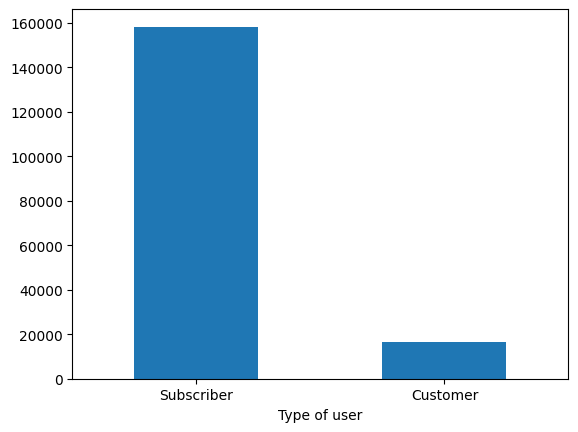

In [50]:
# create bar plot types
(bikes_cleaned.user_type.value_counts().plot(kind = 'bar',rot = 0).set(xlabel = 'Type of user'))
plt.show()

Almost only subscribers. Could this be due to the pricing?

### What did we see in the plots? Which findings?

#### Age of riders
The main target group of riders is between the end of their 20s and 40s. Is this perhaps because young people in big citys don't own a car and therefore rely on bicycles to get from a to b quickly? Or the service is often used by younger tourists?

#### Gender of riders
For the gender groups, the number of trips in male riders is up to 3 times more than the number of trips in females. I think the organization should think about how to make bike riding more attractive for women.

I think the "other" entries are because of not willing to reveal or there are data entry issues.


#### Type of riders
It makes sense that there are more subscribers than customers. Based on quick internet research, monthly membership takes 15 dollars or 150 dollars per year. For regular customers, one trip takes 2 dollars and one day takes 10 dollars. If riders are commuters or long-term users, it does not make sense for them to choose one time or two time purchases instead of being the members.



### Check the top 10 end stations

Last but not least, I would like to know which stations were used the most by the riders. I filter the data according to the 10 most frequently mentioned end and start stations

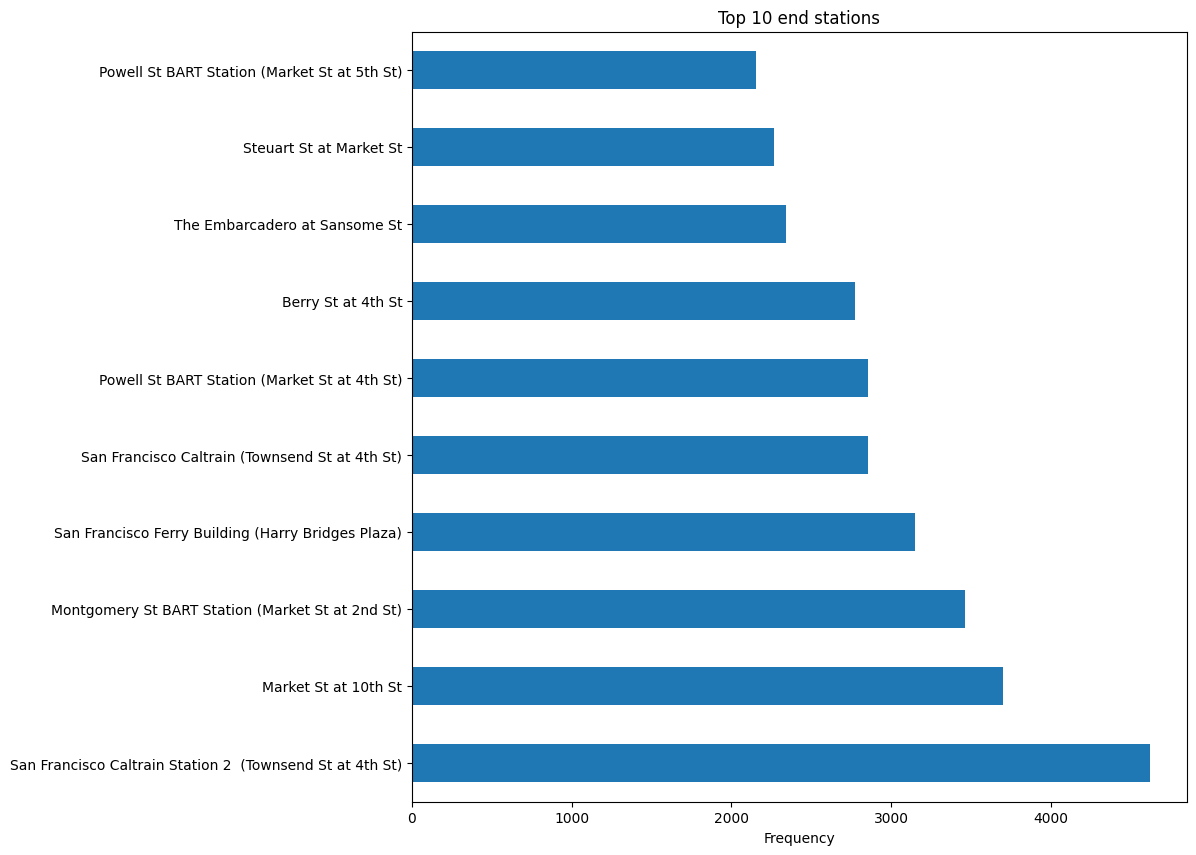

In [35]:
bikes_cleaned['end_station_name'].value_counts().sort_values(ascending = False)[:10].plot(kind = 'barh' ,
                                                                                 figsize = (10,10)).set(xlabel = 'Frequency')
plt.title("Top 10 end stations") 
plt.show()

So it looks like that San Francisco Caltrain Station 2 is the most popular END-Station. Lets check if its also the most populat START-station

### Check the top 10 start stations

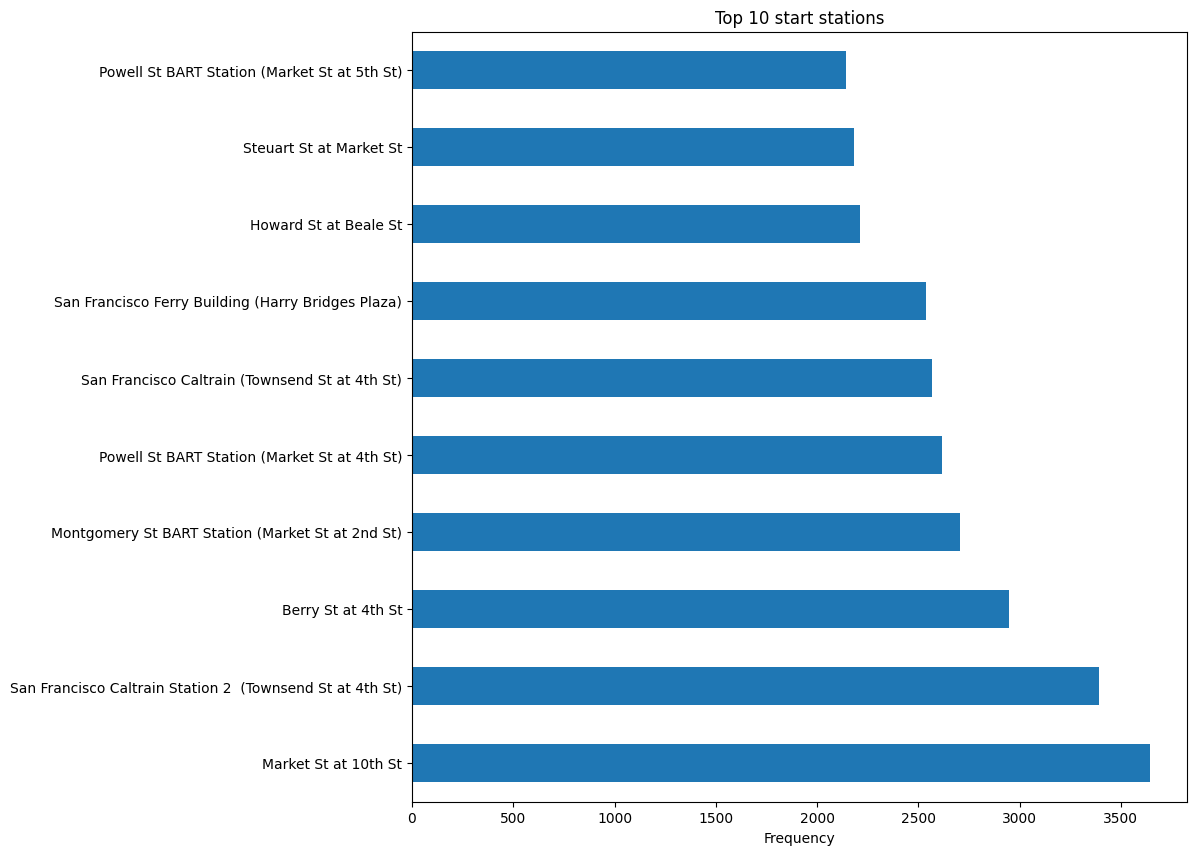

In [53]:
bikes_cleaned['start_station_name'].value_counts().sort_values(ascending = False)[:10].plot(kind = 'barh' ,
                                                                                 figsize = (10,10)).set(xlabel = 'Frequency')
plt.title("Top 10 start stations") 
plt.show()

According to the two graphs for start/end stations, it is immediately apparent that most journeys take place between the two stations Market ST at 10th St and Francisco Caltrain Station 2. These are probably the best located stations to reach work or leisure activities

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

### Cleaning
Since I am interested in the durations of the trips and the age of the people, I first threw NAN values out of the data set. Then I checked if duplicates are available in the dataset.

Also I removed fake birthyears because people over 100 years doesnt rent bikes :D

### Transformation
To get the age of the members, I created a new attribute called "member_age". For this I subtracted the entered year of birth from the current year.

The variable duration_sec, look like right skewed, thats why I used the quantile function to get only data points are above or below a certain limit. With this method I found the outliers and we could see that the most duration data points are between 350 and 800s

# Bivariate Exploration

Let's take a look at this very interesting section. We can actually check the correlation between age and duration.

### Heatmap

In [39]:
# check the correlation value between both variables
y = bikes_cleaned['member_age']
x = bikes_cleaned['duration_sec']
correlation = y.corr(x)
correlation 

0.00725671646433158

In [40]:
# variables to check
variables = ['member_age','duration_sec']

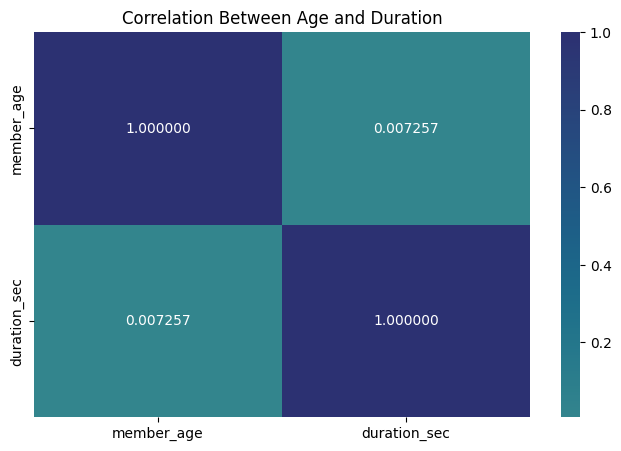

In [41]:
plt.figure(figsize = [8, 5])
sns.heatmap(bikes_cleaned[variables].corr(), annot = True, fmt = '1f',
           cmap = 'crest', center = 0)
plt.title('Correlation Between Age and Duration');

### Scatterplot

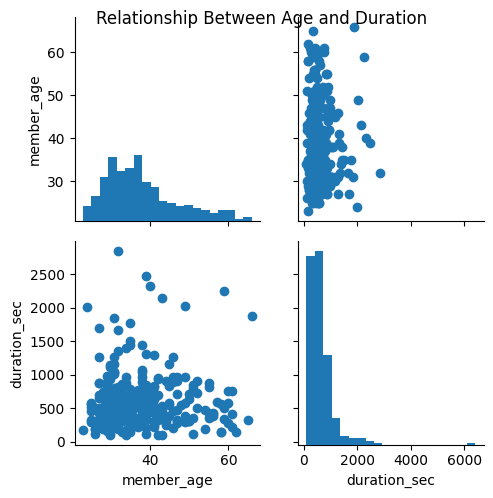

In [42]:
# plot matrix for age and duration
# sample 300 because of clearer plots
samples = np.random.choice(bikes.shape[0], 300, replace = False)
bikes_samp = bikes.loc[samples,:]

g = sns.PairGrid(data = bikes_samp, vars = variables)
g = g.map_diag(plt.hist, bins = 20)
g.map_offdiag(plt.scatter)
g.fig.suptitle('Relationship Between Age and Duration');

Based on the correlation, there is no demonstrable connection at all between duration and age. As a rule, values below -0.6 and above 0.6 are referred to as a statistically recognizable correlation. But the data set for people over 60 is too small to establish a good correlation. Most people are between 30-40 years old

### Boxplot

In [45]:
# define function
def plotFunction(plt, title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

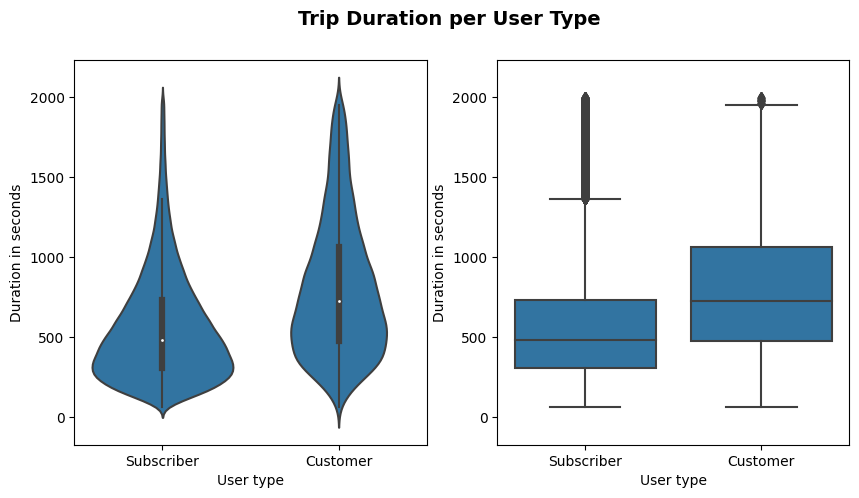

In [46]:
# Set an upper limit of 4000 to remove outliers for the graphs
fig = plt.figure(figsize = [10, 5])
base_color = sns.color_palette()[0]
filter_data = bikes_cleaned.query('duration_sec < 2000')

# left plot: violin plot
plt.subplot(1, 2, 1)
ax1 = sns.violinplot(data = filter_data, x = 'user_type', y = 'duration_sec', color = base_color)
plotFunction(plt,"", "User type", "Duration in seconds")


# right plot: box plot
plt.subplot(1, 2, 2)
sns.boxplot(data = filter_data, x = 'user_type', y = 'duration_sec', color = base_color)
plotFunction(plt,"", "User type", "Duration in seconds")

plt.ylim(ax1.get_ylim()) # set y-axis limits to be same as left plot
fig.suptitle('Trip Duration per User Type', fontsize=14, fontweight='bold')
plt.show();

We can see here, that subscribers on average have a shorter travel time than costumers. This could be because subscribers tend to use the service to get to work quickly, or to go shopping etc. Costumers probably use the service spontaneously to see a sight (tourists) or to take a longer ride through the city.

## Multivariate Exploration

In terms of the user types and Gender , We may want to see the distribution of data when we compare to the age to get a good sense of idea

### Facetgrid - Scatterplot

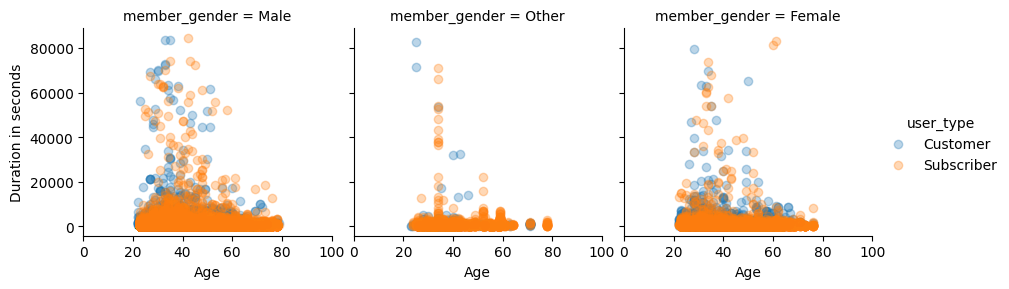

In [47]:
# create compare of Age, User Type and ride duration
g = sns.FacetGrid(data=bikes_cleaned ,col = 'member_gender' , hue = 'user_type')
g.map(plt.scatter , 'member_age','duration_sec' , alpha = 0.3).add_legend()
g.set_xlabels('Age')
g.set_ylabels('Duration in seconds')
g.set_xticklabels()
plt.show()

As we can see that male and female riders whether they are subscriber or customer tend to have a similar duration in terms of age.

### Compare the gender/type/ride duration with an catplot
#### I used the datasample below 2000s of duration because over 95 percent is covered by this

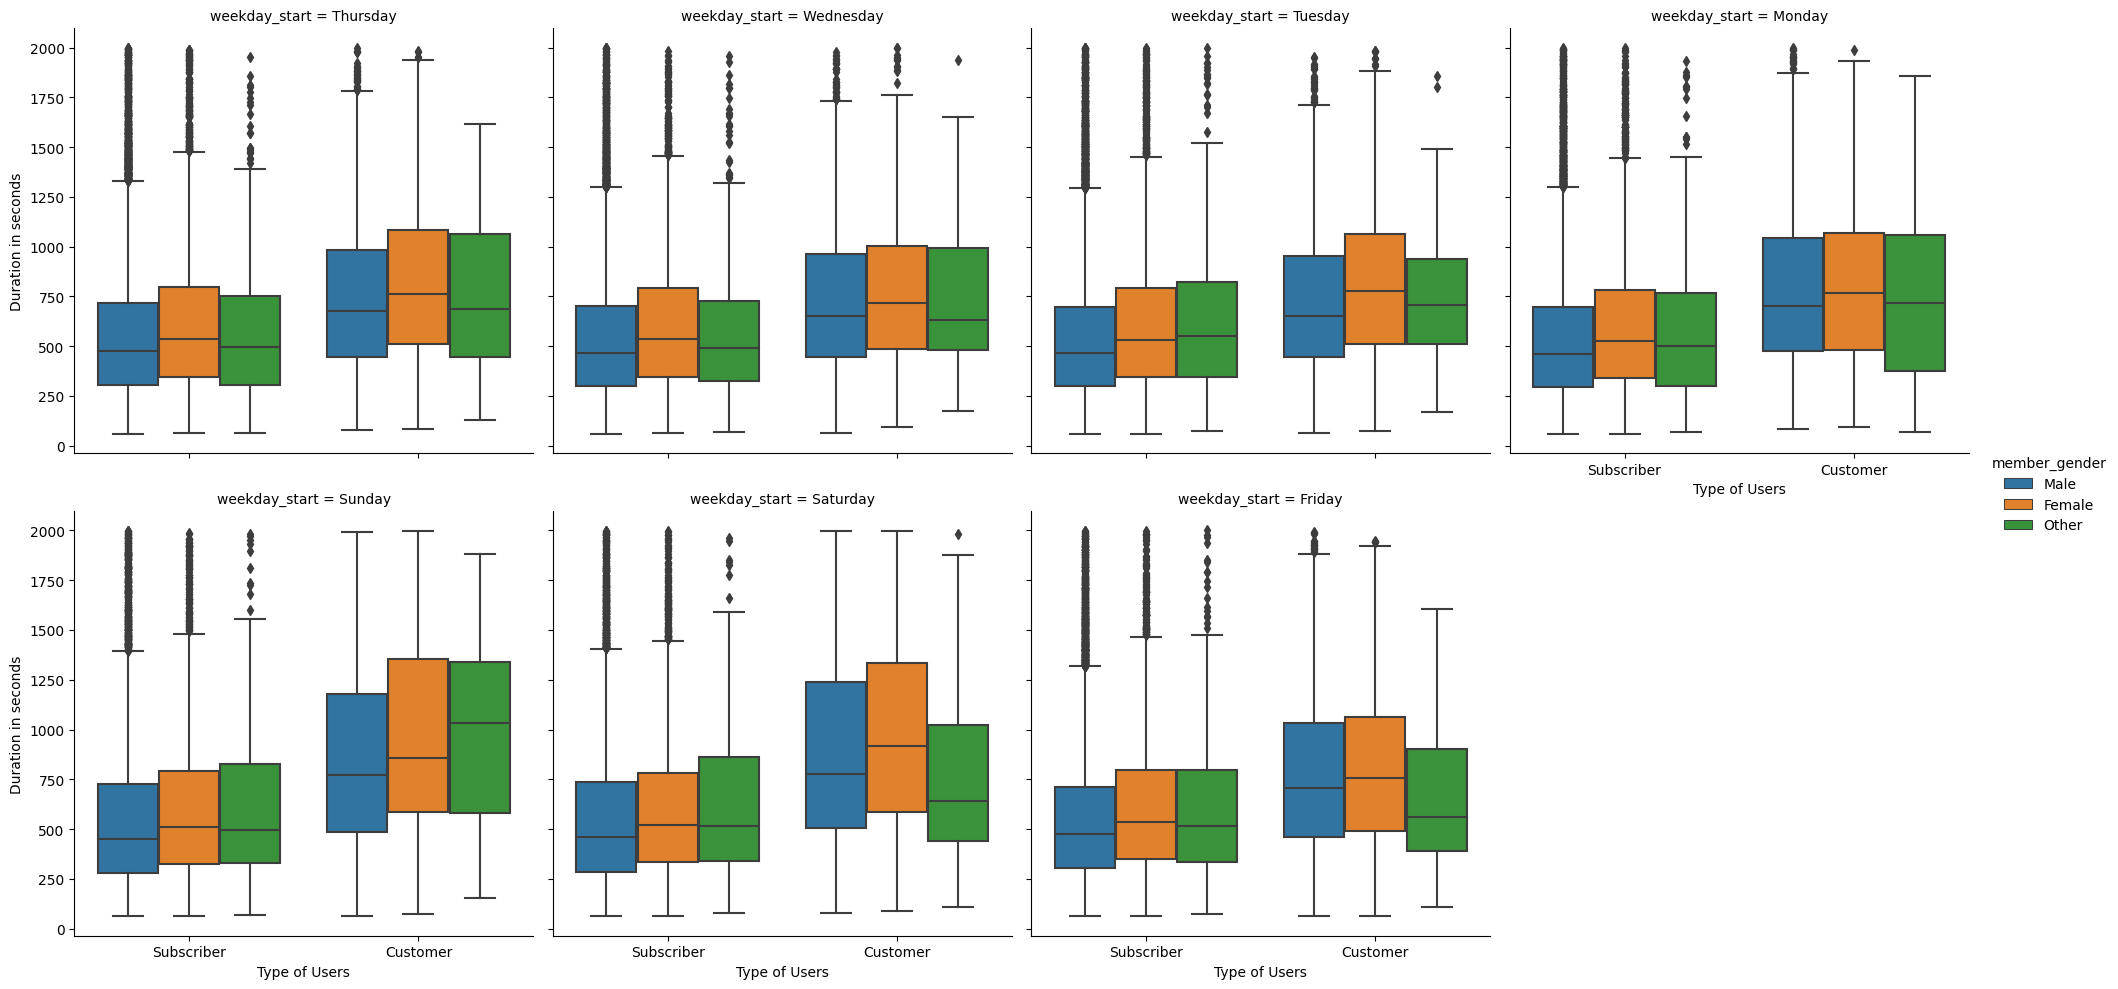

In [54]:
# create Catplot formerly factorplot
g = sns.catplot(x="user_type", y="duration_sec",col = 'weekday_start',hue="member_gender",col_wrap=4, kind="box",
                  data=bikes_cleaned.query('duration_sec <= 2000'))
g.set_xlabels('Type of Users')
g.set_ylabels('Duration in seconds')
plt.show()

What we can see from the graph above is that regardless of gender type, travel times are the longest on a weekend. Which is only logical, as there is more time for leisure.

## Conclusions

- The data only goes up to the year 2019

- The target audience for ford bikesharing should be in their mid-twenties to 40s. At the moment, most rides take place in this age range. 

- As things stand today, it is increasingly male users who use sharing. Perhaps there are ways to make the system more attractive for women

- Due to the fact that the duration of travel times is higher at weekends, it would be expedient to increase the number of weekend users

- Most of the riders are subscriber

- We realize that the majority of the travel durations are on average betwenn 300-450s